# **Libraries**

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

plt.style.use('ggplot')
color_pal = sns.color_palette()

plt.rcParams['figure.figsize'] = 15, 5

# **Data**

In [29]:
df = pd.read_csv("monthly_milk_production.csv", index_col = "Date", parse_dates = True)
df.sort_index(inplace = True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


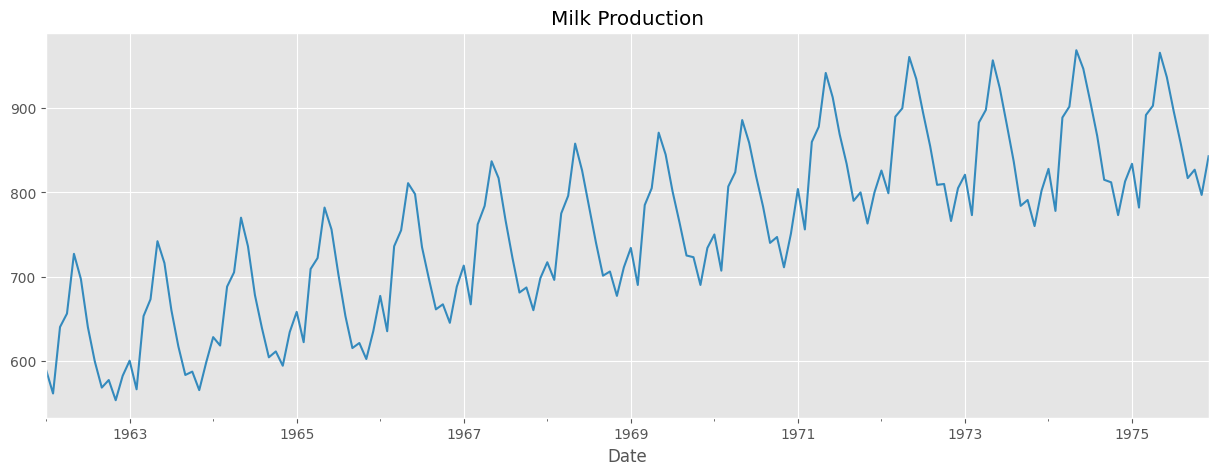

In [31]:
df.plot(title = "Milk Production",
        color = color_pal[1],
        legend = False)

plt.show()

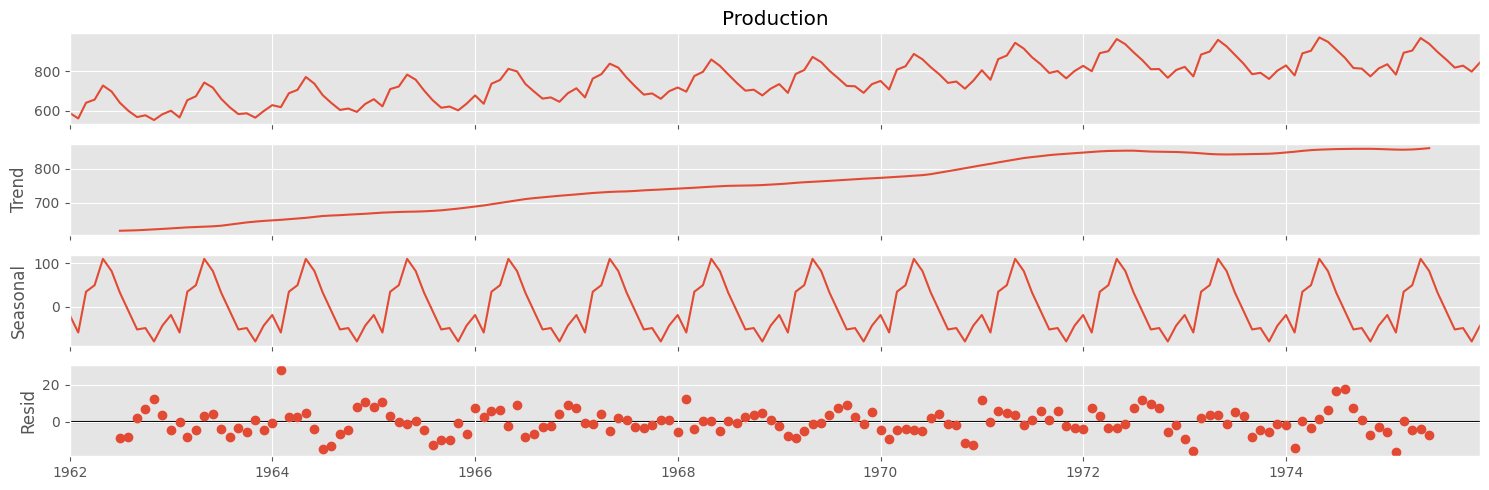

In [32]:
res = seasonal_decompose(df["Production"])
res.plot()
plt.show()

In [41]:
df["Year"] = df.index.year
df["Month"] = df.index.month
df.head()

,Production,Year,Month
Date,,,
1962-01-01,589,1962,1
1962-02-01,561,1962,2
1962-03-01,640,1962,3
1962-04-01,656,1962,4
1962-05-01,727,1962,5


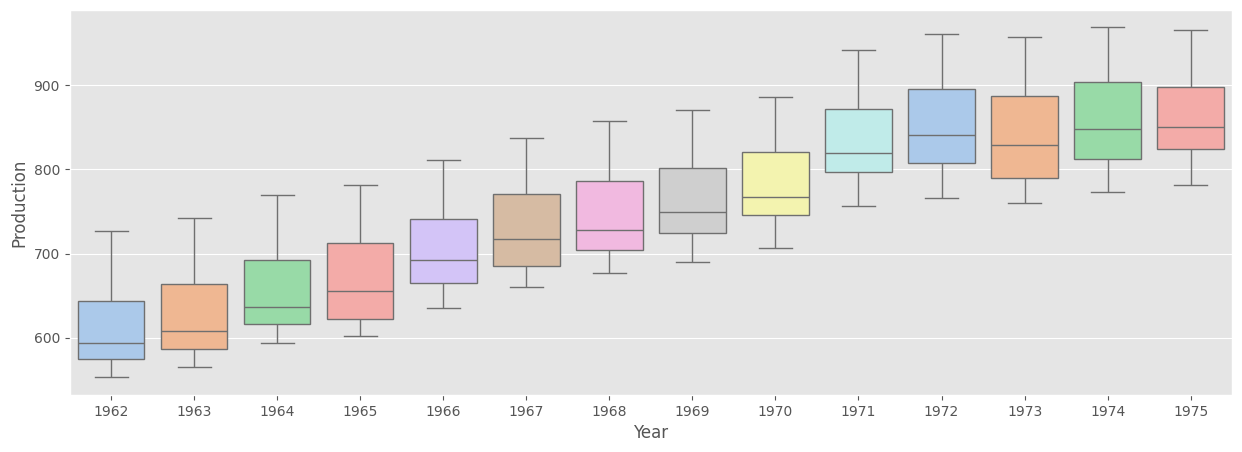

In [49]:
sns.boxplot(data = df, x = "Year", y = "Production", palette = "pastel", hue = "Year", legend = False)
plt.show()

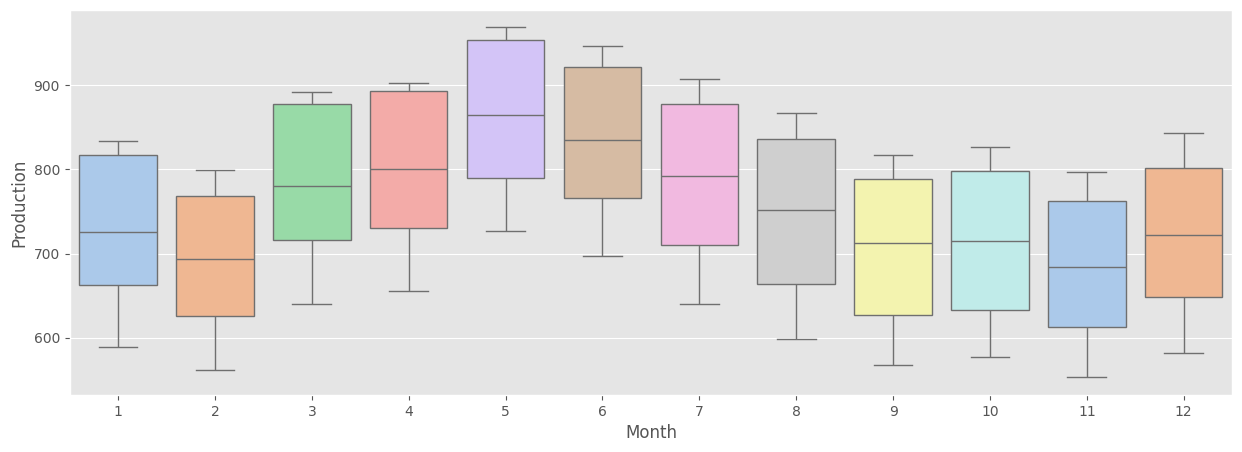

In [55]:
sns.boxplot(data = df, x = "Month", y = "Production", palette = "pastel", hue = "Month", legend = False)
plt.show()

# **Train & Test**

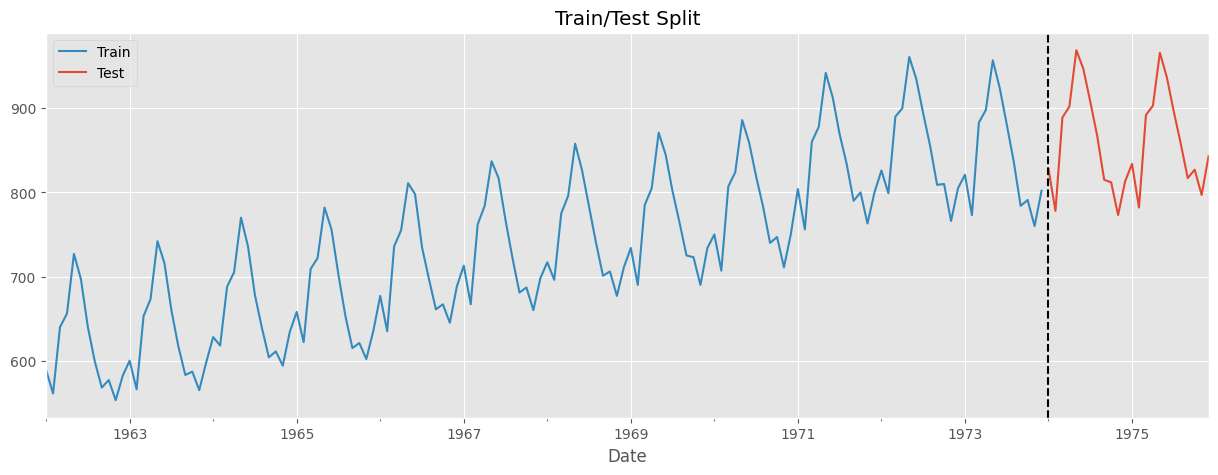

In [43]:
train = df[df.index < "1974-01-01"]
test = df[df.index >= "1974-01-01"]

fig, ax = plt.subplots()

train["Production"].plot(ax = ax , label = "Training Set", color = color_pal[1])
test["Production"].plot(ax = ax, label = "Test Set", color = color_pal[0])

ax.axvline("1974-01-01", color = "black", ls = "--")
plt.title("Train/Test Split") 
plt.legend(["Train", "Test"])

plt.show()

In [57]:
df.columns

Index(['Production', 'Year', 'Month'], dtype='object')

In [59]:
Features = ["Year", "Month"]
Target = "Production"

X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

# **Model**

In [72]:
reg = xgb.XGBRegressor(n_estimators = 1000,
                        early_stopping_round = 50,
                        learning_rate = 0.1)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:88.48949	validation_1-rmse:125.70277


[100]	validation_0-rmse:1.13916	validation_1-rmse:21.22042
[200]	validation_0-rmse:0.25115	validation_1-rmse:21.22975


c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.07002	validation_1-rmse:21.23849
[400]	validation_0-rmse:0.02111	validation_1-rmse:21.23869
[500]	validation_0-rmse:0.01354	validation_1-rmse:21.23943
[600]	validation_0-rmse:0.01354	validation_1-rmse:21.23943
[700]	validation_0-rmse:0.01354	validation_1-rmse:21.23943
[800]	validation_0-rmse:0.01354	validation_1-rmse:21.23943
[900]	validation_0-rmse:0.01354	validation_1-rmse:21.23943
[999]	validation_0-rmse:0.01354	validation_1-rmse:21.23943


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# **Feature Importance**

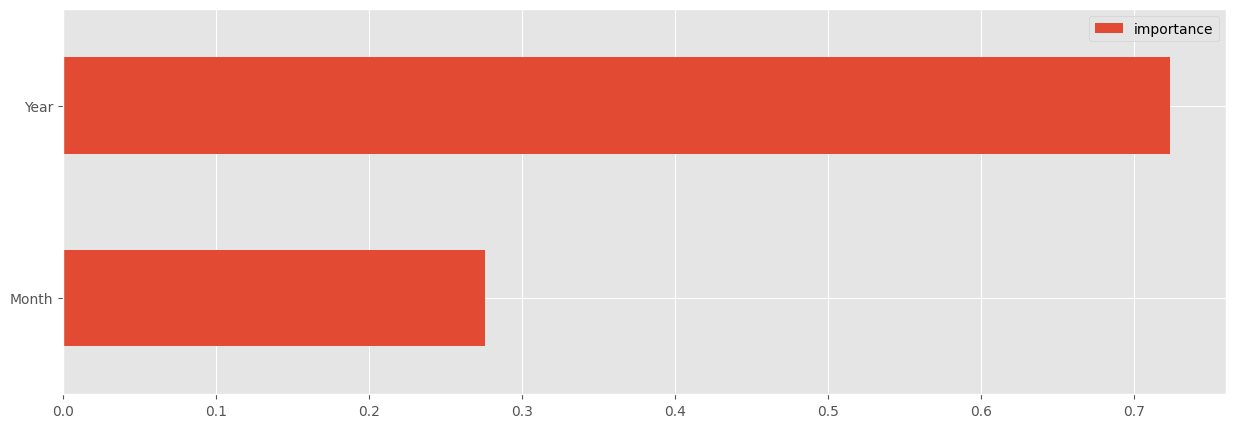

In [73]:
fi = pd.DataFrame(data = reg.feature_importances_,
                index = reg.feature_names_in_,
                columns = ["importance"])


fi.sort_values(by = "importance").plot(kind = "barh")
plt.show()

# **Forecast**

In [75]:
test["prediction"] = reg.predict(X_test)
test.head()

C:\Users\acast\AppData\Local\Temp\ipykernel_24932\3611538061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = reg.predict(X_test)


,Production,Year,Month,prediction
Date,,,,
1974-01-01,828,1974,1,820.999390
1974-02-01,778,1974,2,773.001953
1974-03-01,889,1974,3,882.999451
1974-04-01,902,1974,4,897.996948
1974-05-01,969,1974,5,957.004089


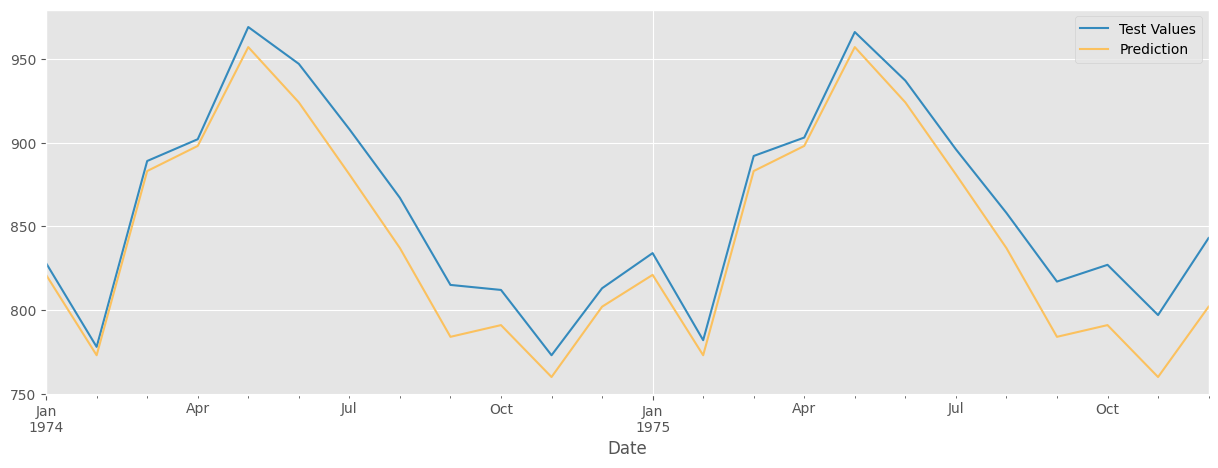

In [84]:
fig, ax = plt.subplots()

test["Production"].plot(ax = ax , label = "Test Values", color = color_pal[1])
test["prediction"].plot(ax = ax, label = "Prediction", color = color_pal[4])
plt.legend(["Test Values", "Prediction"])
plt.show()

In [94]:
root_mean_sq_error_1 = root_mean_squared_error(test["Production"], test["prediction"])  
root_mean_sq_error_1

21.239434390886515

In [92]:
((test["Production"] - test["prediction"])**2).mean()**(1/2)

21.239434390886515

- https://www.youtube.com/watch?v=S8tpSG6Q2H0
- https://www.youtube.com/watch?v=vV12dGe_Fho&t=43s